In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "5,6"
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
from keras import layers, optimizers, regularizers
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, ZeroPadding2D
from keras.models import Model

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)


Using TensorFlow backend.


0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


In [2]:
from keras.utils.np_utils import to_categorical

def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

Text(0.5,1,'3NEX')

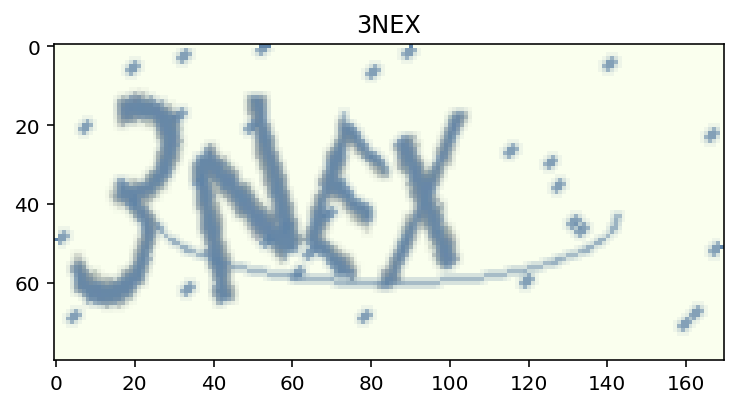

In [3]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))

In [4]:
from keras.models import *
from keras.layers import *

def cnnModel(input_shape):
    x = Input(input_shape)
    X_Input = x
    for i in range(4):
        x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
        x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
        x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
    model = Model(inputs=X_Input, outputs=x, name='cnnModel')
    return model


In [5]:
input_shape = (height, width, 3)
model = cnnModel(input_shape)

In [6]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
#model.fit_generator(gen(), samples_per_epoch=51200, nb_epoch=5,
#                   validation_data=gen(), nb_val_samples=1280)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('train.h5', verbose=1, save_best_only=True)
model.fit_generator(gen(), samples_per_epoch = 25600, epochs = 10, validation_steps = 40, validation_data = gen(), callbacks=[earlystopper, checkpointer])

/home/yqwang16/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=10, validation_steps=40, validation_data=<generator..., callbacks=[<keras.ca..., steps_per_epoch=25600)`
  


Epoch 1/10
25600/25600 [==============================] - 2498s 98ms/step - loss: 1.8130 - c1_loss: 0.4643 - c2_loss: 0.4386 - c3_loss: 0.4638 - c4_loss: 0.4464 - c1_acc: 0.8739 - c2_acc: 0.8804 - c3_acc: 0.8737 - c4_acc: 0.8787 - val_loss: 0.1822 - val_c1_loss: 0.0426 - val_c2_loss: 0.0378 - val_c3_loss: 0.0557 - val_c4_loss: 0.0461 - val_c1_acc: 0.9898 - val_c2_acc: 0.9953 - val_c3_acc: 0.9867 - val_c4_acc: 0.9914
Epoch 2/10
25600/25600 [==============================] - 2493s 97ms/step - loss: 0.1413 - c1_loss: 0.0311 - c2_loss: 0.0348 - c3_loss: 0.0392 - c4_loss: 0.0362 - c1_acc: 0.9933 - c2_acc: 0.9919 - c3_acc: 0.9906 - c4_acc: 0.9918 - val_loss: 0.2113 - val_c1_loss: 0.0480 - val_c2_loss: 0.0583 - val_c3_loss: 0.0545 - val_c4_loss: 0.0504 - val_c1_acc: 0.9938 - val_c2_acc: 0.9914 - val_c3_acc: 0.9914 - val_c4_acc: 0.9914
Epoch 3/10
  676/25600 [..............................] - ETA: 37:09 - loss: 0.0748 - c1_loss: 0.0165 - c2_loss: 0.0188 - c3_loss: 0.0218 - c4_loss: 0.0177 - c1

KeyboardInterrupt: 

In [8]:
model1 = load_model('train.h5')

In [9]:
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 78, 168, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 76, 166, 32)  9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 38, 83, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (